# Лабораторная работа №3: проведение исследований с решающим деревом. Регрессия

Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

Датасет - Electric Motor Temperature. Цель регрессии - предсказать температуру ротора электрического двигателя

In [2]:
dt = pd.read_csv('measures_v2.csv')
dt.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


Значение колонок:

- `u_q` - Измерение q-компоненты напряжения в dq-координатах (В)
- `coolant` - Температура охлаждающей жидкости (°C)
- `stator_winding` - Температура обмотки статора, измеренная термопарами (°C)
- `u_d` - Измерение d-компоненты напряжения в dq-координатах (В)
- `stator_tooth` - Температура зубца статора, измеренная термопарами (°C)
- `motor_speed` - Скорость двигателя (об/мин)
- `i_d` - Измерение d-компоненты тока в dq-координатах (А)
- `i_q` - Измерение q-компоненты тока в dq-координатах (А)
- `pm` - Температура постоянных магнитов, измеренная термопарами и переданная по беспроводной связи (°C)
- `stator_yoke` - Температура ярма статора, измеренная термопарами (°C)
- `ambient` - Температура окружающей среды (°C)
- `torque` - Крутящий момент (Нм)
- `profile_id` - Идентификатор профиля нагрузки/режима

## Бейзлайн

Предсказание решающими деревьями.

In [11]:
# Подготовка данных
X = dt.drop(columns=['pm'])  # Все признаки кроме целевой переменной
y = dt['pm']  # Целевая переменная - температура постоянных магнитов

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создание и обучение модели
lr_model = DecisionTreeRegressor()
lr_model.fit(X_train, y_train)

# Предсказания
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")

# примеры предсказаний
results_sample = pd.DataFrame({
    "y_true": y_test.iloc[:10].values,
    "y_pred": y_pred_test[:10],
})
results_sample


Результаты на тестовой выборке:
MAE: 0.1033
MSE: 0.2759
R2 Score: 0.9992


,y_true,y_pred
0,90.431534,90.190735
1,81.452672,81.511332
2,67.810123,67.916028
3,63.638145,63.643395
4,73.154007,73.087418
5,34.920715,34.991917
6,74.650510,74.665692
7,47.301857,47.075191
8,65.738054,65.803390
9,59.400782,59.416833


## Улучшенный бейзлайн
### Анализ датасета

In [4]:
print("Shape:", dt.shape)

print("\nColumn types:")
print(dt.dtypes)

print("\nMissing values (top 10):")
missing = dt.isna().sum().sort_values(ascending=False)
display(missing.head(10))

print("\nBasic stats (numeric):")
display(dt.describe(include='number').T)


Shape: (1330816, 13)

Column types:
u_q               float64
coolant           float64
stator_winding    float64
u_d               float64
stator_tooth      float64
motor_speed       float64
i_d               float64
i_q               float64
pm                float64
stator_yoke       float64
ambient           float64
torque            float64
profile_id          int64
dtype: object

Missing values (top 10):


u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
dtype: int64


Basic stats (numeric):


,count,mean,std,min,25%,50%,75%,max
u_q,1330816.0,54.279005,44.173234,-25.290930,12.069925,48.938181,90.034393,133.036994
coolant,1330816.0,36.229995,21.786149,10.623751,18.698135,26.900141,49.857487,101.598512
stator_winding,1330816.0,66.342745,28.672061,18.585815,42.787957,65.110129,88.141137,141.362885
u_d,1330816.0,-25.133809,63.091972,-131.530411,-78.690904,-7.429755,1.470271,131.469788
stator_tooth,1330816.0,56.878582,22.952233,18.133976,38.416012,56.036345,75.586682,111.946423
motor_speed,1330816.0,2202.080728,1859.663350,-275.549144,317.110665,1999.976685,3760.639058,6000.015137
i_d,1330816.0,-68.716810,64.933233,-278.003632,-115.406060,-51.093763,-2.979688,0.051897
i_q,1330816.0,37.412782,92.181880,-293.426793,1.095863,15.774007,100.612150,301.707855
pm,1330816.0,58.506776,19.001498,20.856956,43.151582,60.266287,72.008371,113.606628
stator_yoke,1330816.0,48.187965,19.991004,18.076689,31.990333,45.625509,61.460828,101.147964


Распределение признаков

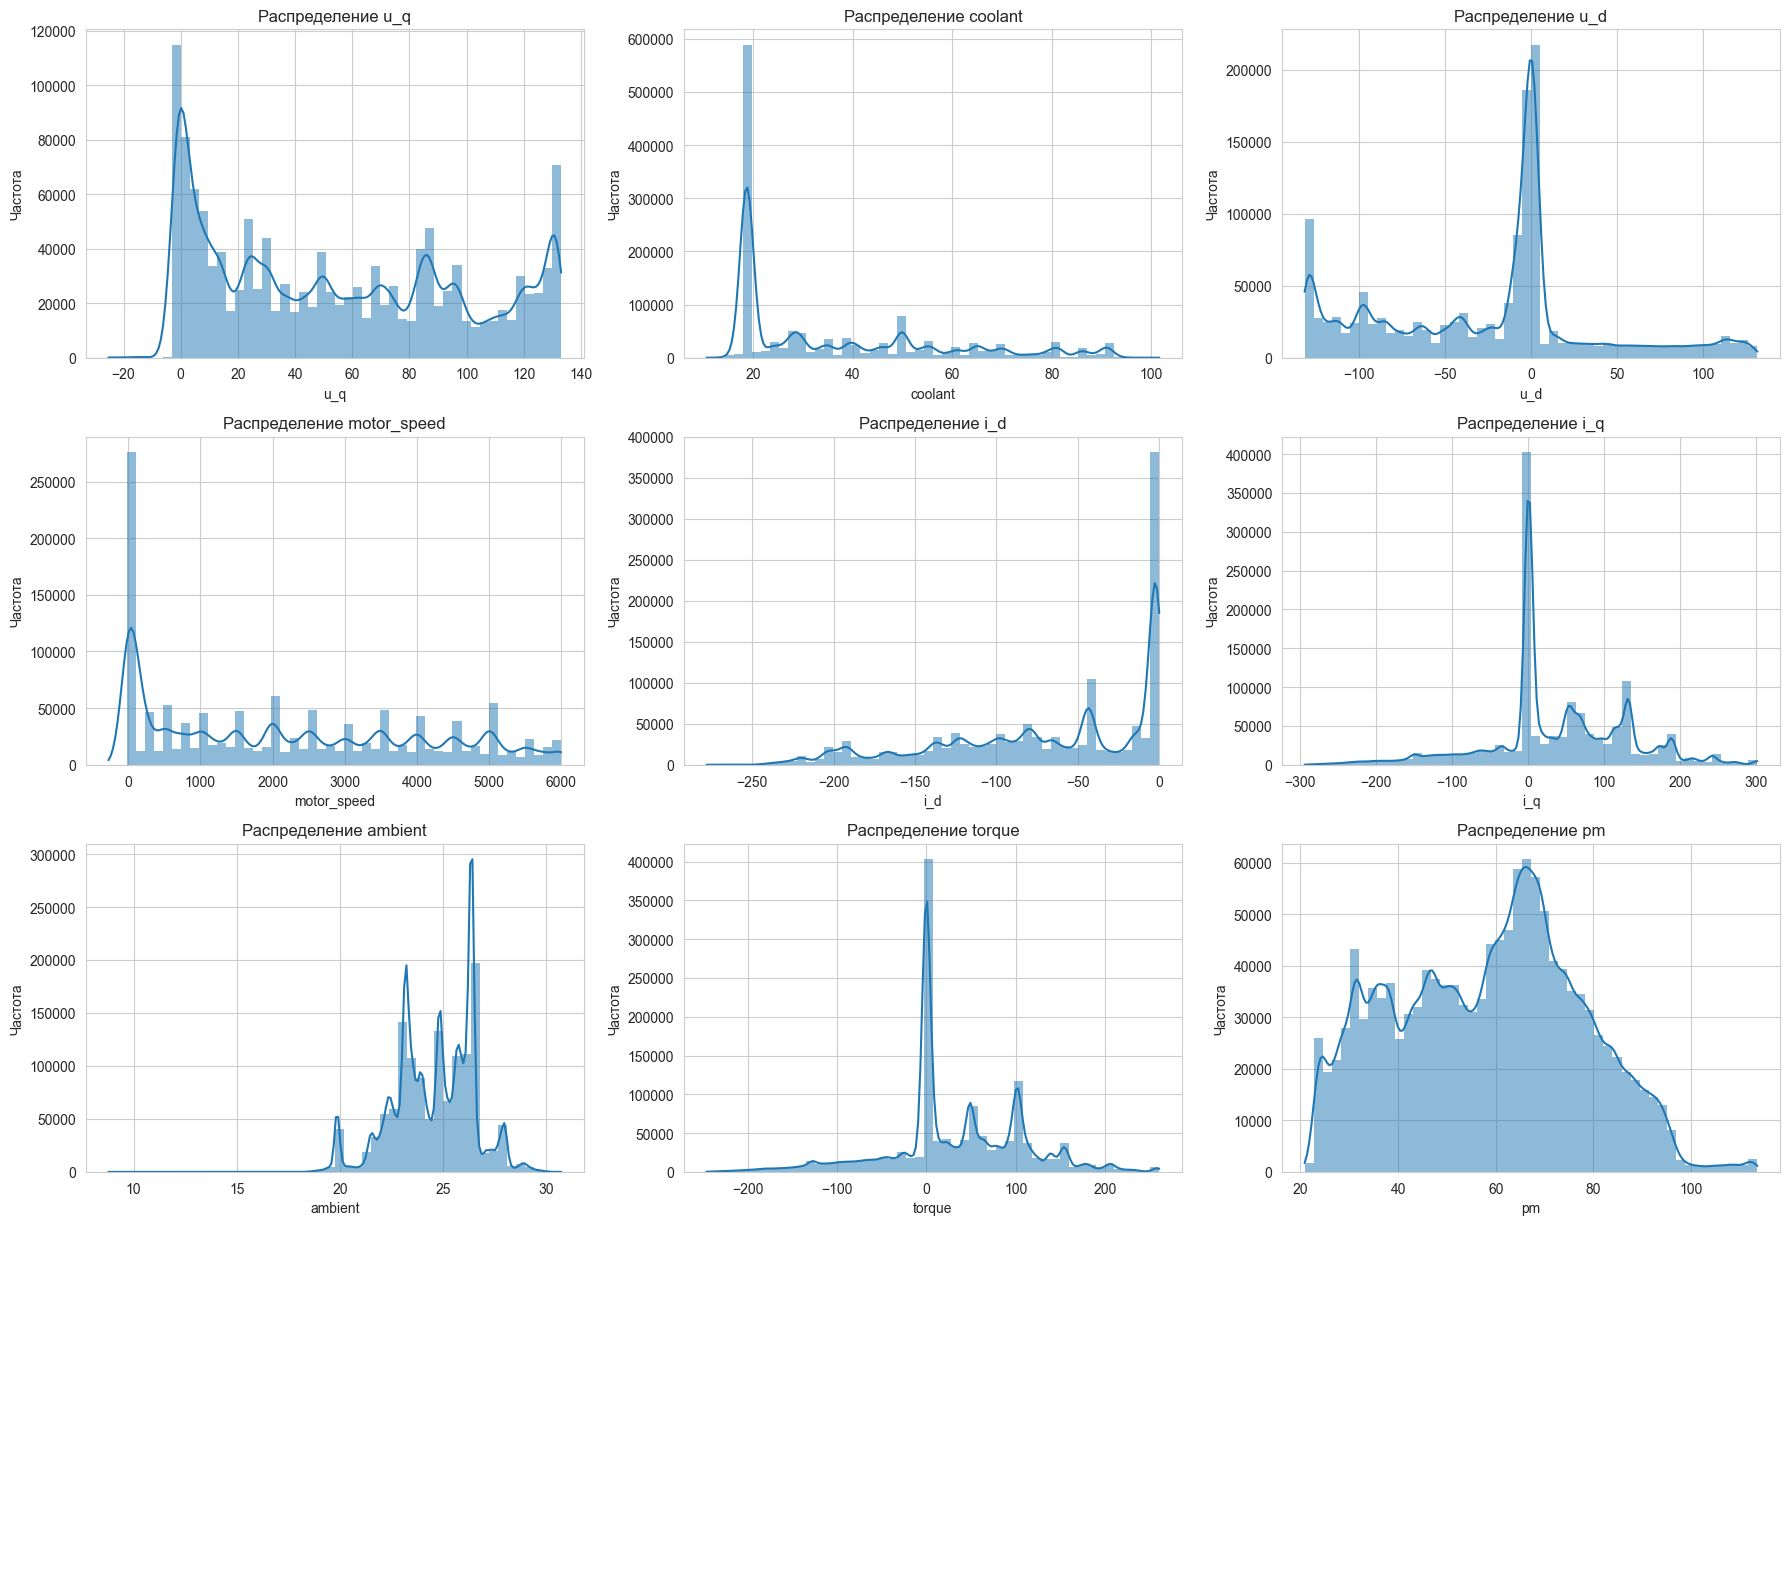

In [5]:
numeric_cols = [
    "u_q",
    "coolant",
    "u_d",
    "motor_speed",
    "i_d",
    "i_q",
    "ambient",
    "torque",
    "pm"
]

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
for ax, col in zip(axes.ravel(), numeric_cols):
    sns.histplot(dt[col], bins=50, kde=True, ax=ax, edgecolor="none")
    ax.set_title(f"Распределение {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Частота")

# скрываем пустые подграфики если столбцов меньше размера сетки
for ax in axes.ravel()[len(numeric_cols) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


**Сильная асимметрия (skewness) и выбросы**

Признаки torque, i_d, coolant и motor_speed демонстрируют выраженную правостороннюю асимметрию с длинными хвостами.

**Разный масштаб признаков**

Диапазоны значений сильно различаются:
motor_speed (0–6000),
u_q (0–250),
coolant (20–100).

Корреляция признаков

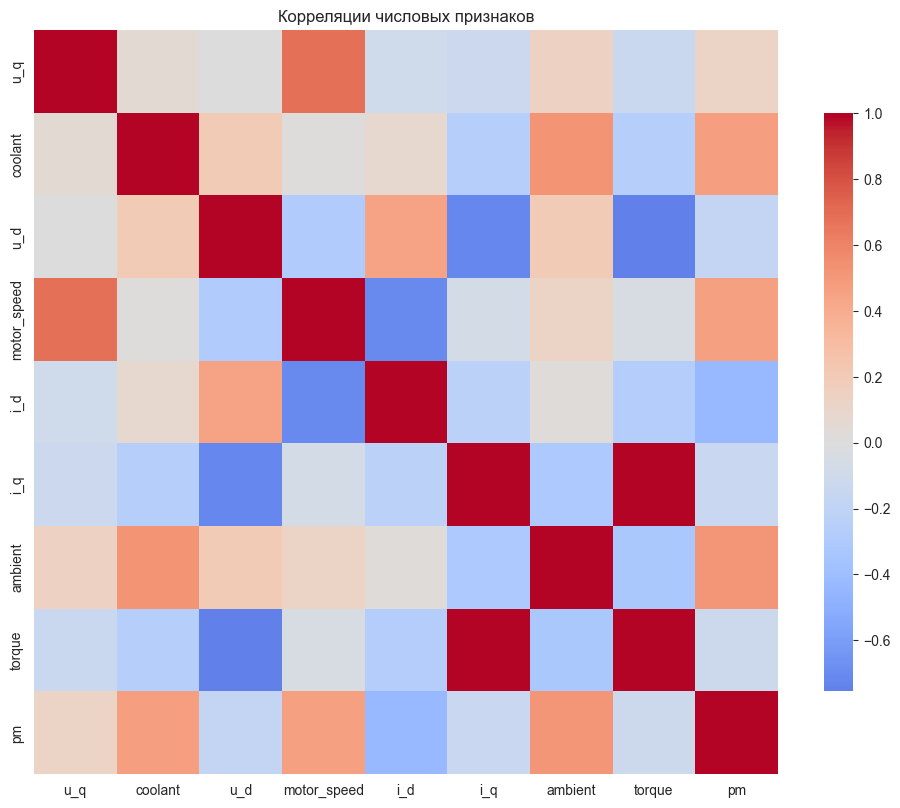

In [6]:
corr = dt[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.75},
)
plt.title("Корреляции числовых признаков")
plt.show()

Высокие корреляции между признаками (u_q ↔ i_q, i_d ↔ i_q, motor_speed ↔ torque) нарушают ключевое предположение линейной регрессии о независимости предикторов.

**Нелинейные зависимости**

Физические процессы (например, связь motor_speed и pm) могут иметь нелинейный характер (квадратичная, экспоненциальная зависимость). Линейная регрессия не сможет их корректно описать без трансформации признаков.

**Слабая информативность некоторых признаков**

ambient и coolant демонстрируют слабые корреляции с другими признаками. Если они также слабо связаны с pm, их включение увеличит шум и снизит обобщающую способность модели.

In [26]:
# Создаем копию для добавления признаков
dt_enhanced = dt.copy()

# 1. Электрическая мощность: P = u_q * i_q + u_d * i_d
dt_enhanced['power'] = dt_enhanced['u_q'] * dt_enhanced['i_q'] + dt_enhanced['u_d'] * dt_enhanced['i_d']

# 2. Разница температур (охлаждающая способность)
dt_enhanced['temp_diff_coolant'] = dt_enhanced['stator_winding'] - dt_enhanced['coolant']
dt_enhanced['temp_diff_ambient'] = dt_enhanced['stator_winding'] - dt_enhanced['ambient']

# 3. Отношение тока к скорости (эффективность)
dt_enhanced['i_q_per_speed'] = dt_enhanced['i_q'] / (dt_enhanced['motor_speed'] + 1e-6)
dt_enhanced['torque_per_speed'] = dt_enhanced['torque'] / (dt_enhanced['motor_speed'] + 1e-6)

# 4. Квадраты токов (тепловыделение пропорционально I²)
dt_enhanced['i_q_squared'] = dt_enhanced['i_q'] ** 2
dt_enhanced['i_d_squared'] = dt_enhanced['i_d'] ** 2

# 5. Взаимодействие температур
dt_enhanced['temp_product'] = dt_enhanced['stator_winding'] * dt_enhanced['coolant']

Логарфимирование признаков

In [27]:
dt_enhanced['log_torque'] = np.sign(dt_enhanced['torque']) * np.log1p(np.abs(dt_enhanced['torque']) + 1e-6)
dt_enhanced.drop(columns=['log_torque'], inplace=True)

# Для coolant: обрезаем отрицательные значения до минимально допустимого
min_coolant = max(0.1, dt['coolant'].min())  # Минимум 0.1°C
dt_enhanced['log_coolant'] = np.log1p(np.where(dt_enhanced['coolant'] < 0, min_coolant, dt_enhanced['coolant']))
dt_enhanced.drop(columns=['coolant'], inplace=True)

Линейная регрессия на улучшенном бейзлайне

In [28]:
# Подготовка данных
X_enhanced = dt_enhanced.drop(columns=['pm'])  # Все признаки кроме целевой переменной
y_enhanced = dt_enhanced['pm']  # Целевая переменная - температура постоянных магнитов

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor())
])

# Создание и обучение модели
lr_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_test = lr_pipeline.predict(X_test)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")

# примеры предсказаний
results_sample = pd.DataFrame({
    "y_true": y_test.iloc[:10].values,
    "y_pred": y_pred_test[:10],
})
results_sample


Результаты на тестовой выборке:
MAE: 0.1038
MSE: 0.2821
R2 Score: 0.9992


,y_true,y_pred
0,90.431534,90.188606
1,81.452672,81.485550
2,67.810123,67.598860
3,63.638145,63.638368
4,73.154007,73.254463
5,34.920715,34.785496
6,74.650510,74.694883
7,47.301857,47.204391
8,65.738054,65.657749
9,59.400782,59.400073


## Кастомная реализация

In [31]:
class CustomDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=10, min_samples_split=20, max_thresholds=20):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_thresholds = max_thresholds
        self.tree = None
    
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < self.min_samples_split:
            return None
        
        best_mse = float('inf')
        best_split = None
        current_mse = np.var(y) * len(y)
        
        for feature in range(n_features):
            values = X[:, feature]
            thresholds = np.percentile(values, np.linspace(0, 100, min(self.max_thresholds, len(np.unique(values)))))
            
            for threshold in thresholds:
                left_mask = values <= threshold
                n_left = np.sum(left_mask)
                
                if n_left < self.min_samples_split or n_left > n_samples - self.min_samples_split:
                    continue
                
                left_y = y[left_mask]
                right_y = y[~left_mask]
                mse = np.var(left_y) * len(left_y) + np.var(right_y) * len(right_y)
                
                if mse < best_mse:
                    best_mse = mse
                    best_split = (feature, threshold)
        
        return best_split if best_mse < current_mse else None
    
    def _build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)
        
        split = self._best_split(X, y)
        if split is None:
            return np.mean(y)
        
        feature, threshold = split
        left_mask = X[:, feature] <= threshold
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        }
    
    def fit(self, X, y):
        self.tree = self._build_tree(np.array(X), np.array(y))
        return self
    
    def _predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        return self._predict_one(x, tree['left'] if x[tree['feature']] <= tree['threshold'] else tree['right'])
    
    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in np.array(X)])


Бейзлайн

In [32]:
# Подготовка данных
X = dt.drop(columns=['pm'])  # Все признаки кроме целевой переменной
y = dt['pm']  # Целевая переменная - температура постоянных магнитов

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создание и обучение модели
lr_model = CustomDecisionTreeRegressor()
lr_model.fit(X_train, y_train)

# Предсказания
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")

# примеры предсказаний
results_sample = pd.DataFrame({
    "y_true": y_test.iloc[:10].values,
    "y_pred": y_pred_test[:10],
})
results_sample


Результаты на тестовой выборке:
MAE: 3.2661
MSE: 25.9841
R2 Score: 0.9281


,y_true,y_pred
0,90.431534,92.381320
1,81.452672,76.735391
2,67.810123,51.818251
3,63.638145,80.387469
4,73.154007,74.873401
5,34.920715,35.359414
6,74.650510,73.612625
7,47.301857,46.422141
8,65.738054,68.752573
9,59.400782,62.712688


Улучшенный бейзлайн

In [33]:
# Подготовка данных
X_enhanced = dt_enhanced.drop(columns=['pm'])  # Все признаки кроме целевой переменной
y_enhanced = dt_enhanced['pm']  # Целевая переменная - температура постоянных магнитов

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', CustomDecisionTreeRegressor())
])

# Создание и обучение модели
lr_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_test = lr_pipeline.predict(X_test)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")

# примеры предсказаний
results_sample = pd.DataFrame({
    "y_true": y_test.iloc[:10].values,
    "y_pred": y_pred_test[:10],
})
results_sample


Результаты на тестовой выборке:
MAE: 3.1497
MSE: 24.0560
R2 Score: 0.9334


/Users/t.golubev/programming/mai-ai-frameworks/.venv/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,y_true,y_pred
0,90.431534,90.387045
1,81.452672,76.156786
2,67.810123,49.322384
3,63.638145,74.645749
4,73.154007,74.873401
5,34.920715,34.462760
6,74.650510,74.645749
7,47.301857,45.747233
8,65.738054,68.752573
9,59.400782,57.152977
